# AdaBoost Classification Model (Clean Version)

Ce notebook utilise l'utilitaire DataPreprocessor pour préparer les données et entraîner un modèle AdaBoost pour la classification de signaux de trading crypto.

In [19]:
import sys
import os
# Ajoute le dossier racine du projet au sys.path
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
print("Project root ajouté au sys.path :", project_root)


Project root ajouté au sys.path : c:\Users\enzo.cAo\Documents\ST-Finance\EI LOB\ifcob


In [20]:
# Imports principaux
import pandas as pd
import numpy as np
from prediction_model.data_preprocess import DataPreprocessor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
# Chargement des données ETH et XBT
eth_path = "../../data/features/DATA_0/ETH_EUR.parquet"
xbt_path = "../../data/features/DATA_0/XBT_EUR.parquet"
df_eth = pd.read_parquet(eth_path)
df_xbt = pd.read_parquet(xbt_path)
print(f"ETH shape: {df_eth.shape}")
print(f"XBT shape: {df_xbt.shape}")

ETH shape: (1817685, 18)
XBT shape: (563395, 18)


In [22]:
# Initialisation du DataPreprocessor
preprocessor = DataPreprocessor()

# Définition des colonnes features (XBT)
feature_columns = [
    "V-bid-5-levels",
    "V-ask-5-levels",
    "slope-bid-5-levels",
    "slope-ask-5-levels"
]

feature_target_columns = [
    "V-bid-5-levels",
    "V-ask-5-levels",
    "slope-bid-5-levels",
    "slope-ask-5-levels"
]

target_column = "return-all-signed-for-5-ms"

# Préparation des données (split train/test inclus)
X_train, X_test, y_train, y_test = preprocessor.prepare_data(
    features_df=df_xbt,
    target_df=df_eth,
    feature_columns=feature_columns,
    features_columns_target=feature_target_columns,
    target_column=target_column,
    test_size=0.2,
    target_lag=5,
)

print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")
print(f"Label mapping: {preprocessor.get_label_mapping()}")

=== PRÉPARATION DES DONNÉES ADABOOST ===
Étape 1: Extraction du target 'return-all-signed-for-5-ms'...
Target shape: (1817685,)
Étape 2: Sélection des features du features_df...
Features sélectionnées: ['V-bid-5-levels', 'V-ask-5-levels', 'slope-bid-5-levels', 'slope-ask-5-levels']
Features shape avant dropna: (563395, 4)
Features shape après dropna: (562697, 4)
Étape 2b: Sélection des features du target_df avec lag...
Features target sélectionnées: ['V-bid-5-levels', 'V-ask-5-levels', 'slope-bid-5-levels', 'slope-ask-5-levels']
Target features shape après shift (lag=5): (1817685, 4)
Target features shape après dropna: (1814881, 4)
Étape 3: Alignement temporel avec np.searchsorted...
Features après filtrage: (1817685, 4)
Indices filtrés: 1817685
Étape 4: Création des DataFrames nettoyés...
Étape 4b: Ajout des features du target_df après synchronisation et lag...
Target features après alignement: (1814881, 4)
Features combinées shape: (1817685, 8)
Colonnes finales: ['V-bid-5-levels', 'V

In [23]:
# Affichage des données avant l'entraînement
print("=== DONNÉES AVANT ENTRAÎNEMENT ===")
print(f"\nX_train shape: {X_train.shape}")
print(f"X_train:\n{X_train[:5]}")
print(f"\ny_train shape: {y_train.shape}")
print(f"y_train:\n{y_train[:10]}")
print(f"\nX_test shape: {X_test.shape}")
print(f"X_test:\n{X_test[:5]}")
print(f"\ny_test shape: {y_test.shape}")
print(f"y_test:\n{y_test[:10]}")
print(f"\nDistribution des classes dans y_train:")
unique, counts = np.unique(y_train, return_counts=True)
for u, c in zip(unique, counts):
    print(f"Classe {u}: {c} échantillons ({c/len(y_train)*100:.2f}%)")

=== DONNÉES AVANT ENTRAÎNEMENT ===

X_train shape: (1451904, 8)
X_train:
[[ 8.21151910e+00  7.47207400e+00 -5.84544704e-01  1.17771853e+00
   1.32389727e+02  7.54174759e+01 -3.62565896e-03  5.35619016e-03]
 [ 8.21151910e+00  7.47207400e+00 -5.84544704e-01  1.17771853e+00
   1.32389727e+02  4.25751100e+01 -3.62565896e-03  6.81149150e-03]
 [ 8.21151910e+00  7.47207400e+00 -5.84544704e-01  1.17771853e+00
   1.32389727e+02  7.68954290e+01 -3.62565896e-03  3.51126203e-03]
 [ 8.21151910e+00  7.47207400e+00 -5.84544704e-01  1.17771853e+00
   1.49496442e+02  7.68954290e+01 -2.74254018e-03  3.51126203e-03]
 [ 8.21151910e+00  7.47207400e+00 -5.84544704e-01  1.17771853e+00
   1.15168181e+02  7.68954290e+01 -2.17073845e-03  3.51126203e-03]]

y_train shape: (1451904,)
y_train:
[1 1 1 1 1 1 1 1 1 1]

X_test shape: (362977, 8)
X_test:
[[ 7.39530519e+00  4.93576890e-01 -4.32706956e-01  2.93773884e+01
   3.46398130e+01  8.58404716e+01 -7.21712902e-03  4.65980664e-03]
 [ 7.39530519e+00  4.93576890e-01 -

In [24]:
# Calcul des poids pour équilibrer les classes
class_weights = compute_class_weight('balanced', classes=unique, y=y_train)
print(f"Class weights: {dict(zip(unique, class_weights))}")

# Création des sample weights
sample_weights = np.array([class_weights[label] for label in y_train])
print(f"Sample weights shape: {sample_weights.shape}")
print(f"Sample weights min/max: {sample_weights.min():.4f}/{sample_weights.max():.4f}")

Class weights: {np.int64(0): np.float64(4.377872792073476), np.int64(1): np.float64(0.5644683344206158)}
Sample weights shape: (1451904,)
Sample weights min/max: 0.5645/4.3779


In [25]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Initialisation du modèle AdaBoost avec sklearn

# Création du modèle AdaBoost avec un arbre de décision comme estimateur de base
ada_classifier = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=3),
    n_estimators=100,
    learning_rate=0.1,
    random_state=42
)

print("Modèle AdaBoost initialisé avec sklearn")

Modèle AdaBoost initialisé avec sklearn


In [26]:
ada_classifier.fit(X_train, y_train, sample_weight=sample_weights)
print("Modèle AdaBoost entraîné!")

Modèle AdaBoost entraîné!


In [27]:
# Prédictions et évaluation
y_pred = ada_classifier.predict(X_test)
y_train_pred = ada_classifier.predict(X_train)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_pred)
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print("\nClassification report (test):")
print(classification_report(y_test, y_pred))
print("\nConfusion matrix (test):")
print(confusion_matrix(y_test, y_pred))

Train Accuracy: 0.7395
Test Accuracy: 0.7390

Classification report (test):
              precision    recall  f1-score   support

           0       0.17      0.42      0.24     36424
           1       0.92      0.78      0.84    326553

    accuracy                           0.74    362977
   macro avg       0.55      0.60      0.54    362977
weighted avg       0.85      0.74      0.78    362977


Confusion matrix (test):
[[ 15151  21273]
 [ 73450 253103]]


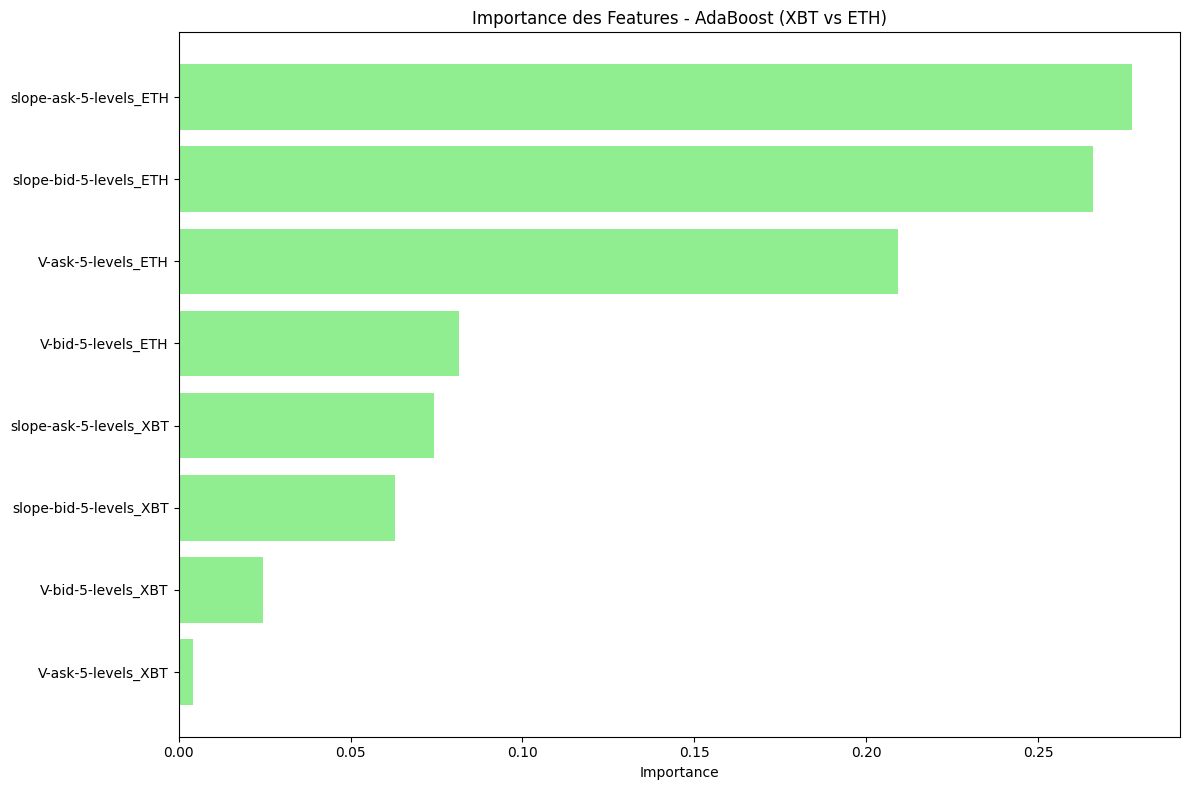


Importances des features (avec suffixes XBT/ETH):
slope-ask-5-levels_ETH: 0.2774
slope-bid-5-levels_ETH: 0.2658
V-ask-5-levels_ETH: 0.2093
V-bid-5-levels_ETH: 0.0815
slope-ask-5-levels_XBT: 0.0743
slope-bid-5-levels_XBT: 0.0629
V-bid-5-levels_XBT: 0.0246
V-ask-5-levels_XBT: 0.0042


In [28]:

# Ajout de suffixes pour distinguer les sources XBT et ETH
xbt_features = [f"{col}_XBT" for col in feature_columns]
eth_features = [f"{col}_ETH" for col in feature_target_columns if col != target_column]

# Concaténation des deux listes dans l'ordre d'entrée du modèle
actual_feature_names = xbt_features + eth_features

# Vérification des dimensions avec le modèle
if len(actual_feature_names) == len(ada_classifier.feature_importances_):
    # Création du DataFrame des importances corrigées
    feature_importance_corrected = pd.DataFrame({
        'feature': actual_feature_names,
        'importance': ada_classifier.feature_importances_
    }).sort_values('importance', ascending=False)

    # Affichage du barplot
    plt.figure(figsize=(12, 8))
    plt.barh(feature_importance_corrected['feature'], feature_importance_corrected['importance'], color='lightgreen')
    plt.xlabel('Importance')
    plt.title('Importance des Features - AdaBoost (XBT vs ETH)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    # Affichage textuel des importances
    print("\nImportances des features (avec suffixes XBT/ETH):")
    for idx, row in feature_importance_corrected.iterrows():
        print(f"{row['feature']}: {row['importance']:.4f}")
else:
    print(f"❌ Erreur: {len(actual_feature_names)} noms vs {len(ada_classifier.feature_importances_)} importances")


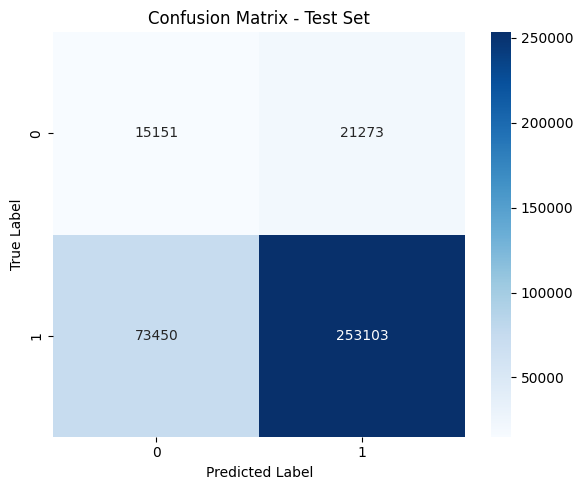

In [29]:
# Visualisation de la matrice de confusion
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

##

In [30]:

# Définition des colonnes features (XBT)
feature_columns = [
    "V-bid-5-levels",
    "V-ask-5-levels",
    "slope-bid-5-levels",
    "slope-ask-5-levels"
]

target_column = "return-all-signed-for-5-ms"

# Préparation des données (split train/test inclus)
X_train, X_test, y_train, y_test = preprocessor.prepare_data(
    features_df=df_xbt,
    target_df=df_eth,
    feature_columns=feature_columns,
    target_column=target_column,
    test_size=0.2
)
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")
print(f"Label mapping: {preprocessor.get_label_mapping()}")

=== PRÉPARATION DES DONNÉES ADABOOST ===
Étape 1: Extraction du target 'return-all-signed-for-5-ms'...
Target shape: (1817685,)
Étape 2: Sélection des features du features_df...
Features sélectionnées: ['V-bid-5-levels', 'V-ask-5-levels', 'slope-bid-5-levels', 'slope-ask-5-levels']
Features shape avant dropna: (563395, 4)
Features shape après dropna: (562697, 4)
Étape 3: Alignement temporel avec np.searchsorted...
Features après filtrage: (1817685, 4)
Indices filtrés: 1817685
Étape 4: Création des DataFrames nettoyés...
Données après dropna et filtrage NaN: (1817685, 4)
Target après dropna et filtrage NaN: (1817685,)
Distribution des classes:
return-all-signed-for-5-ms
-1     202297
 0    1615386
 1          2
Name: count, dtype: int64
Proportions des classes:
return-all-signed-for-5-ms
-1    0.111294
 0    0.888705
 1    0.000001
Name: proportion, dtype: float64
Étape 5: Conversion en arrays numpy...

=== RÉSULTAT FINAL ===
Features (X): (1817685, 4)
Labels encodés (y): (1817685,)
Map

In [31]:
# Affichage des données avec les nouveaux features
print("=== DONNÉES AVEC NOUVEAUX FEATURES ===")
print(f"\nX_train shape: {X_train.shape}")
print(f"X_train:\n{X_train[:5]}")
print(f"\ny_train shape: {y_train.shape}")
print(f"y_train:\n{y_train[:10]}")
print(f"\nX_test shape: {X_test.shape}")
print(f"X_test:\n{X_test[:5]}")
print(f"\ny_test shape: {y_test.shape}")
print(f"y_test:\n{y_test[:10]}")
print(f"\nDistribution des classes dans y_train:")
unique, counts = np.unique(y_train, return_counts=True)
for u, c in zip(unique, counts):
    print(f"Classe {u}: {c} échantillons ({c/len(y_train)*100:.2f}%)")

=== DONNÉES AVEC NOUVEAUX FEATURES ===

X_train shape: (1454148, 4)
X_train:
[[ 8.2115191   7.472074   -0.5845447   1.17771853]
 [ 8.2115191   7.472074   -0.5845447   1.17771853]
 [ 8.2115191   7.472074   -0.5845447   1.17771853]
 [ 8.2115191   7.472074   -0.5845447   1.17771853]
 [ 8.2115191   7.472074   -0.5845447   1.17771853]]

y_train shape: (1454148,)
y_train:
[1 1 1 1 1 1 1 1 1 1]

X_test shape: (363537, 4)
X_test:
[[ 7.78442349  2.31406029 -0.21838483 10.03320524]
 [ 7.78442349  2.31406029 -0.21838483 10.03320524]
 [ 7.78442349  2.31406029 -0.21838483 10.03320524]
 [ 7.78442349  2.31406029 -0.21838483 10.03320524]
 [ 7.78442349  2.31406029 -0.21838483 10.03320524]]

y_test shape: (363537,)
y_test:
[1 1 1 1 1 1 1 1 1 1]

Distribution des classes dans y_train:
Classe 0: 165980 échantillons (11.41%)
Classe 1: 1288168 échantillons (88.59%)


In [32]:
# Calcul des poids pour équilibrer les classes avec les nouveaux features
class_weights_new = compute_class_weight('balanced', classes=unique, y=y_train)
print(f"Class weights (nouveaux features): {dict(zip(unique, class_weights_new))}")
sample_weights_new = np.array([class_weights_new[label] for label in y_train])
print(f"Sample weights shape: {sample_weights_new.shape}")
print(f"Sample weights min/max: {sample_weights_new.min():.4f}/{sample_weights_new.max():.4f}")

Class weights (nouveaux features): {np.int64(0): np.float64(4.380491625497048), np.int64(1): np.float64(0.5644248265754156)}
Sample weights shape: (1454148,)
Sample weights min/max: 0.5644/4.3805


In [33]:
# Création et entraînement du modèle AdaBoost avec les nouveaux features
ada_classifier_new = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=3),
    n_estimators=100,
    learning_rate=0.1,
    random_state=42
)
ada_classifier_new.fit(X_train, y_train, sample_weight=sample_weights_new)
print("Modèle AdaBoost entraîné avec les nouveaux features!")

Modèle AdaBoost entraîné avec les nouveaux features!


In [34]:
# Prédictions et évaluation du modèle avec les nouveaux features
y_pred_new = ada_classifier_new.predict(X_test)
y_train_pred_new = ada_classifier_new.predict(X_train)
train_acc_new = accuracy_score(y_train, y_train_pred_new)
test_acc_new = accuracy_score(y_test, y_pred_new)
print(f"Train Accuracy (nouveaux features): {train_acc_new:.4f}")
print(f"Test Accuracy (nouveaux features): {test_acc_new:.4f}")
print("\nClassification report (test - nouveaux features):")
print(classification_report(y_test, y_pred_new))
print("\nConfusion matrix (test - nouveaux features):")
print(confusion_matrix(y_test, y_pred_new))

Train Accuracy (nouveaux features): 0.1443
Test Accuracy (nouveaux features): 0.1256

Classification report (test - nouveaux features):
              precision    recall  f1-score   support

           0       0.10      0.95      0.18     36317
           1       0.85      0.03      0.07    327218
           2       0.00      0.00      0.00         2

    accuracy                           0.13    363537
   macro avg       0.32      0.33      0.08    363537
weighted avg       0.78      0.13      0.08    363537


Confusion matrix (test - nouveaux features):
[[ 34367   1950      0]
 [315928  11290      0]
 [     2      0      0]]


c:\Users\enzo.cAo\Documents\ST-Finance\EI LOB\ifcob\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\enzo.cAo\Documents\ST-Finance\EI LOB\ifcob\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\enzo.cAo\Documents\ST-Finance\EI LOB\ifcob\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

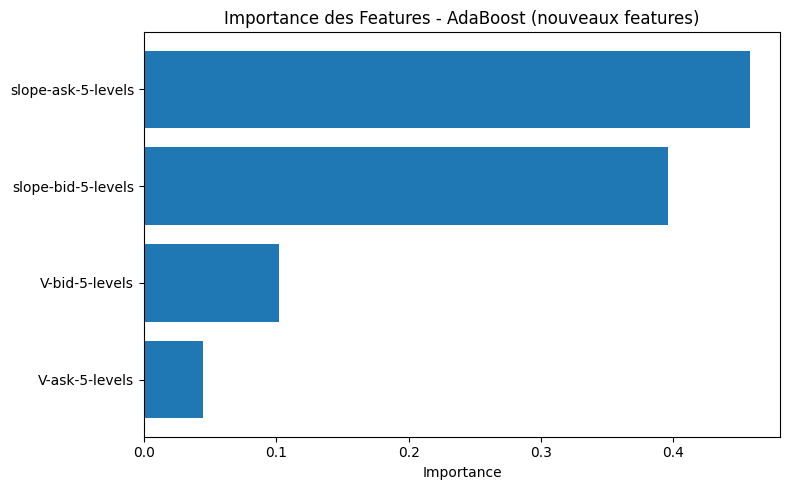


Importances des features:
slope-ask-5-levels: 0.4577
slope-bid-5-levels: 0.3959
V-bid-5-levels: 0.1018
V-ask-5-levels: 0.0446


In [35]:
# Visualisation des importances des nouveaux features
feature_importance_new = pd.DataFrame({
    'feature': feature_columns,
    'importance': ada_classifier_new.feature_importances_
}).sort_values('importance', ascending=False)


plt.figure(figsize=(8, 5))
plt.barh(feature_importance_new['feature'], feature_importance_new['importance'])
plt.xlabel('Importance')
plt.title('Importance des Features - AdaBoost (nouveaux features)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
print("\nImportances des features:")
for idx, row in feature_importance_new.iterrows():
    print(f"{row['feature']}: {row['importance']:.4f}")

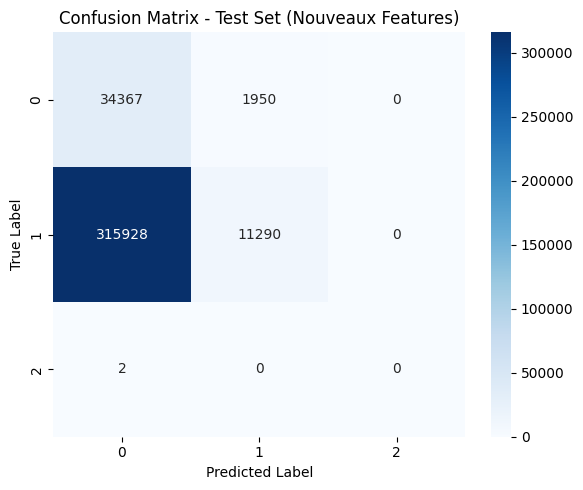

In [36]:
# Visualisation de la matrice de confusion (nouveaux features)
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_new), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test Set (Nouveaux Features)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [37]:
# Comparaison des performances entre l'ancien et le nouveau modèle
print("=== COMPARAISON DES PERFORMANCES ===\n")
try:
    print(f"Modèle précédent:")
    print(f"  - Train Accuracy: {train_acc:.4f}")
    print(f"  - Test Accuracy: {test_acc:.4f}")
except:
    print("Ancien modèle non disponible dans ce kernel.")
print(f"\nModèle avec nouveaux features:")
print(f"  - Train Accuracy: {train_acc_new:.4f}")
print(f"  - Test Accuracy: {test_acc_new:.4f}")
print(f"  - Nombre de features: {len(feature_columns)}")

=== COMPARAISON DES PERFORMANCES ===

Modèle précédent:
  - Train Accuracy: 0.7395
  - Test Accuracy: 0.7390

Modèle avec nouveaux features:
  - Train Accuracy: 0.1443
  - Test Accuracy: 0.1256
  - Nombre de features: 4
